In [4]:
import numpy as np
import pandas as pd
import pandas_profiling
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [2]:
data = pd.read_csv('AirPassengers.csv')

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
pandas_profiling.ProfileReport(data)

In [6]:
#Convert Month object into datetime
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index(data['Month'])
data.drop('Month', axis=1, inplace=True)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
ts = data['#Passengers']

## Check for stationary

* A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time and an autocovariance that does not depend on time.

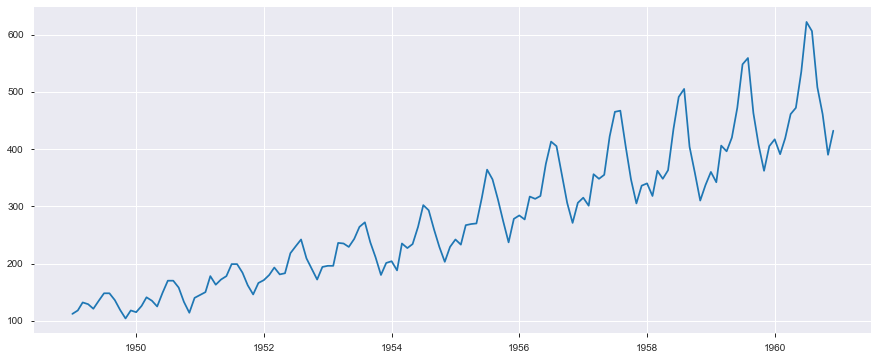

In [9]:
plt.plot(ts)
plt.show()

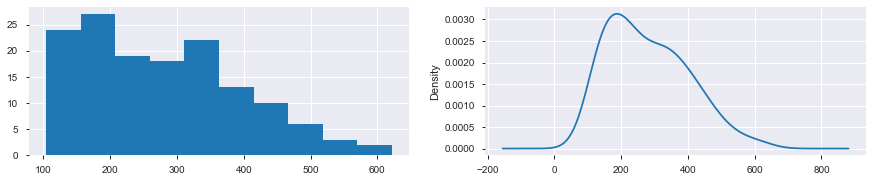

In [10]:
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind='kde')
plt.show()

* We’ll be using the rolling statistics plots along with Dickey-Fuller test results

In [12]:
from statsmodels.tsa.stattools import adfuller

In [20]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    st = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

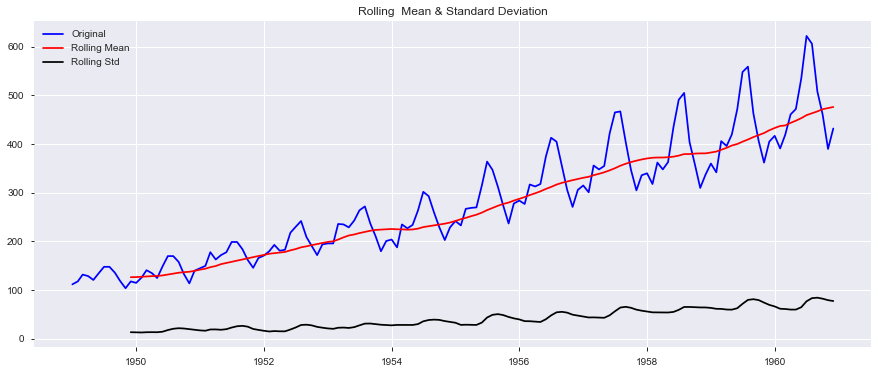

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [21]:
test_stationarity(ts)

* Standard deviation has very less variation but mean is increasing continously. Hence, it's not a stationary series. Also, the test statistic is way more than the critical values (compare signed values and not the absolute values).

## Make time series stationary

* Its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

* Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:

* Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
* Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.
* The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

* We can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity.

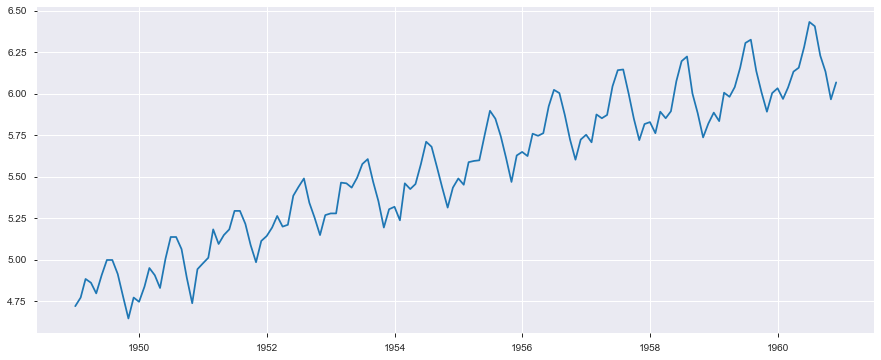

In [23]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

* In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

** Aggregation – taking average for a time period like monthly/weekly averages
** Smoothing – taking rolling averages
** Polynomial Fitting – fit a regression model

* We will apply smoothing here.

* Moving average: in this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

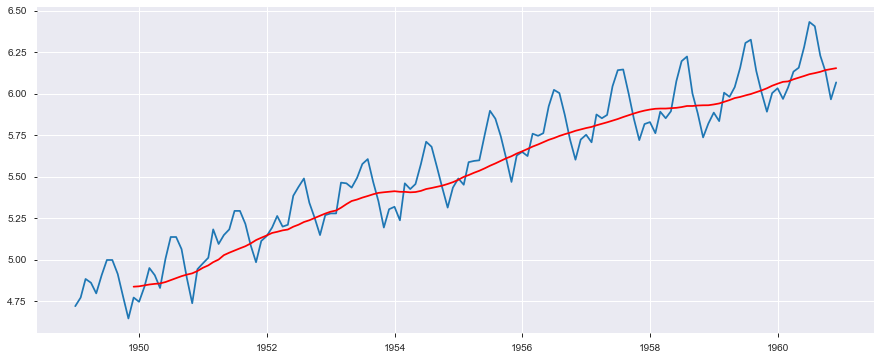

In [25]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color = 'red')
plt.show()

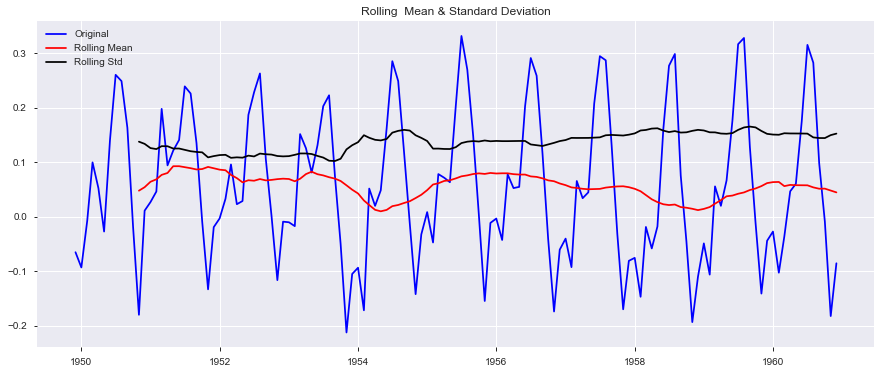

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [26]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

* The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series. However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

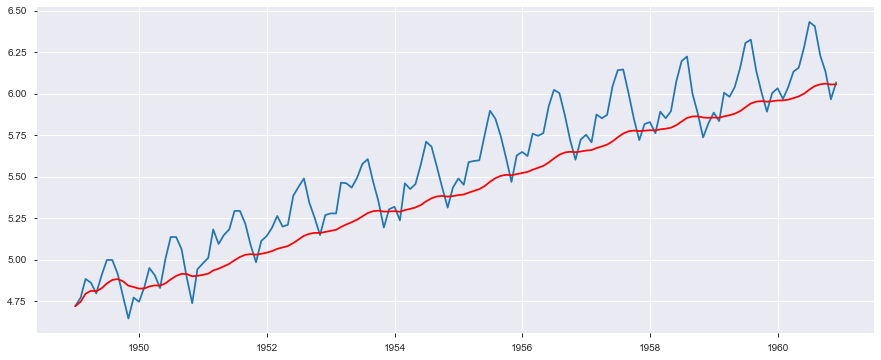

In [36]:
exp_weighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color='red')
plt.show()

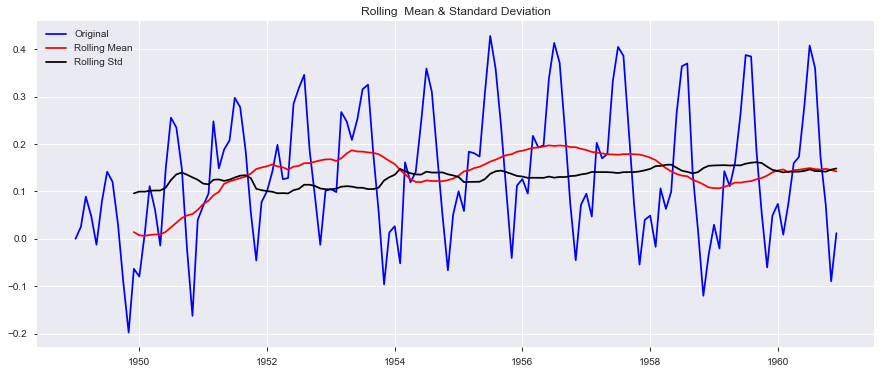

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [37]:
ts_log_ema_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ema_diff)

## Eliminating trend and seasonality

* Two methods:

** Differencing (taking the differece with a particular time lag)
** Decomposition (modeling both trend and seasonality and removing them from the model)

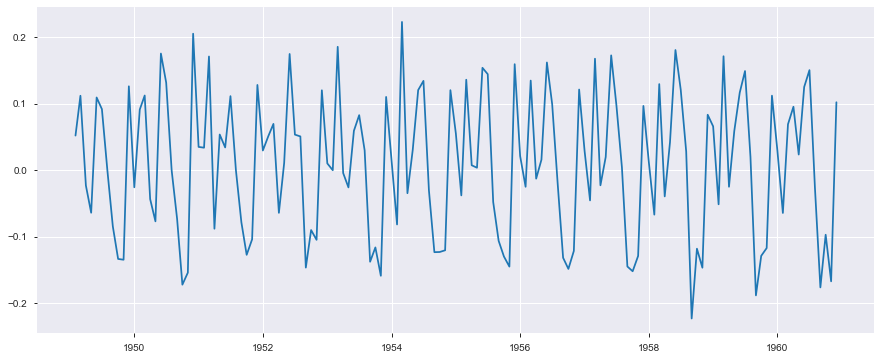

In [40]:
# Differencing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

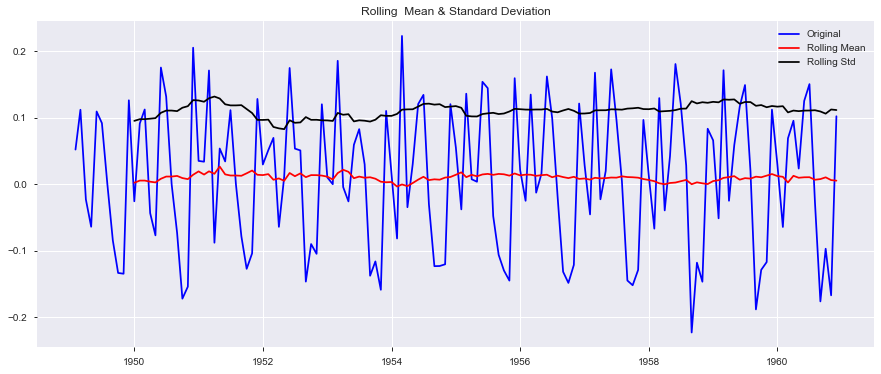

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [41]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

* We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications.

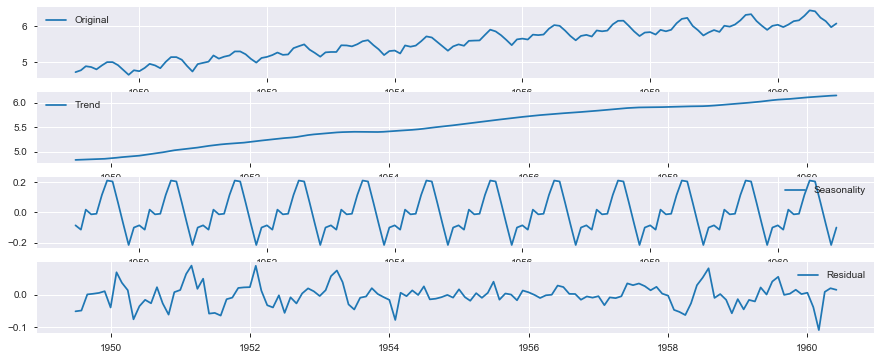

In [43]:
# Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')
plt.show()

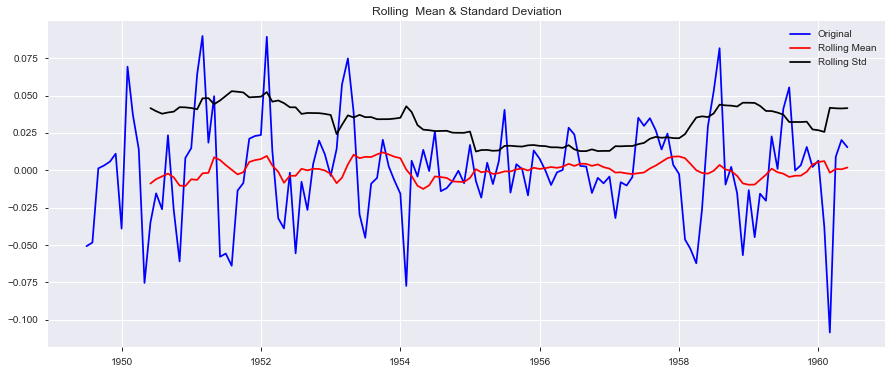

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [44]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

* The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary.

## Forecasting a Time Series

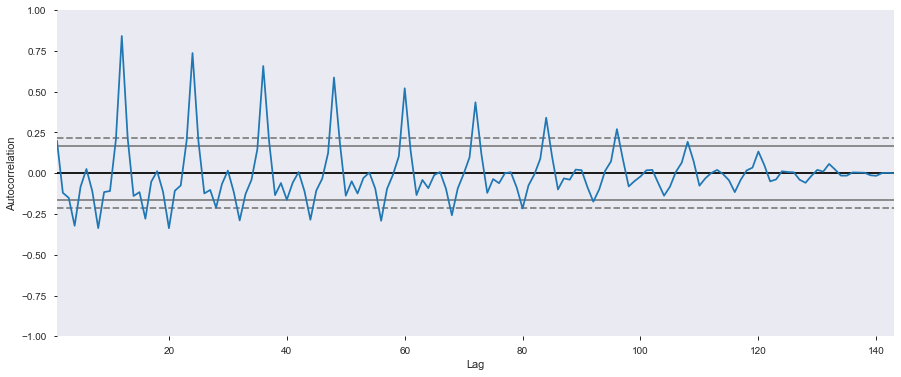

In [45]:
#ACF plot
pd.plotting.autocorrelation_plot(ts_log_diff)
plt.show()

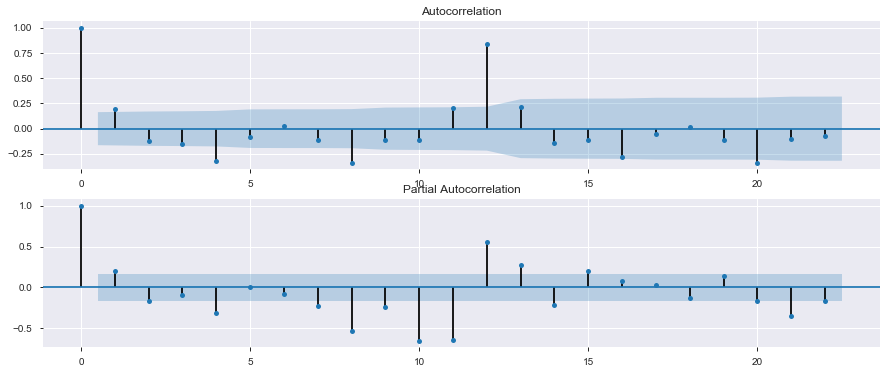

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca())
plt.show()

In [49]:
#Another method
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20, fft=False)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

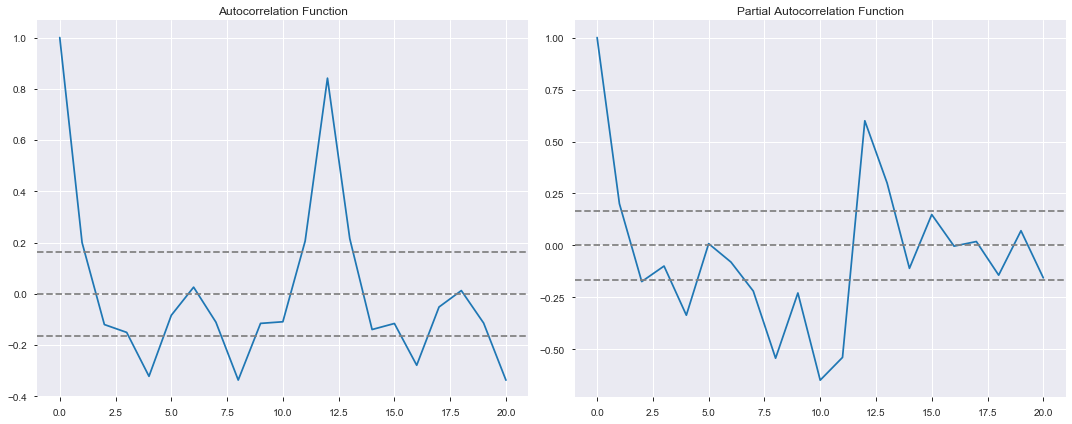

In [50]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.

In [51]:
from statsmodels.tsa.arima_model import ARIMA, ARMAResults

C:\Users\Tuan\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

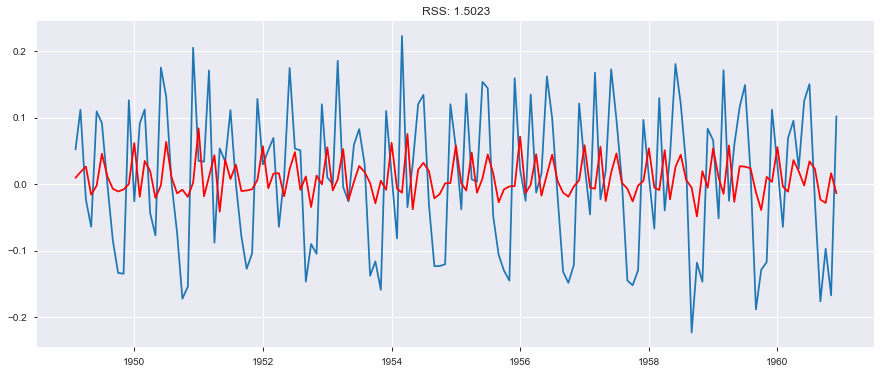

In [52]:
# AR Model
model = ARIMA(ts_log, order = (2,1,0))
results_AR = model.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff)**2)) #Residual sum of squares

Text(0.5, 1.0, 'RSS: 1.4721')

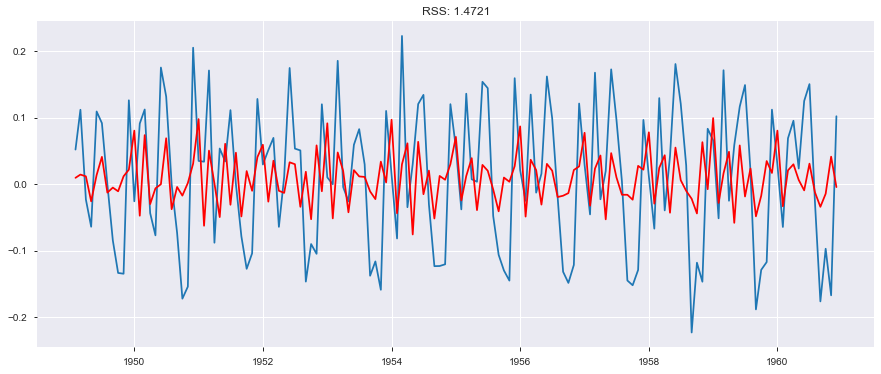

In [53]:
# MA Model
model = ARIMA(ts_log, order= (0, 1, 2))  
results_MA = model.fit(disp = -1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: 1.0292')

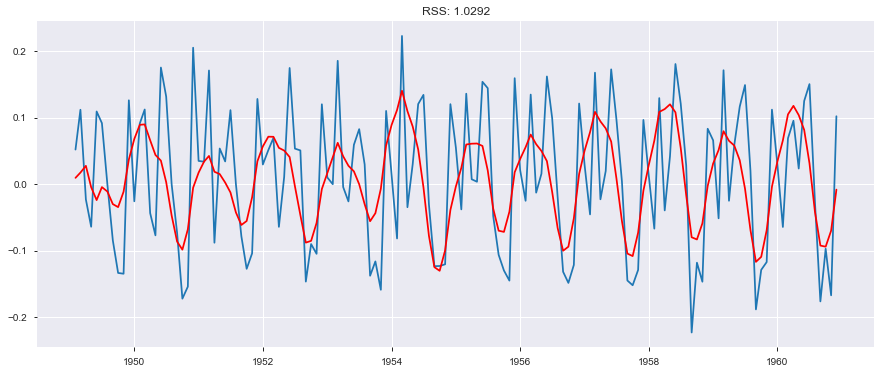

In [54]:
# Combine Model
model = ARIMA(ts_log, order = (2, 1, 2))  
results_ARIMA = model.fit(disp = -1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ts_log_diff)**2))

In [55]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [56]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [57]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1046')

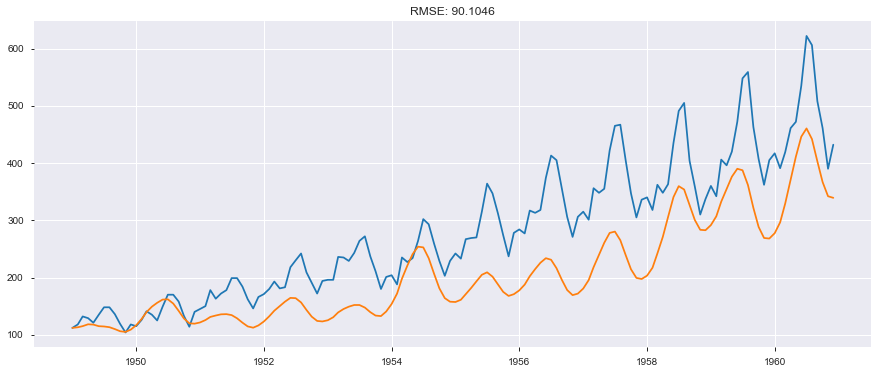

In [58]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [59]:
# https://www.kaggle.com/chirag19/time-series-analysis-with-python-beginner